# **상점 신용카드 매출 예측**

- 목적
    - 2016.06.01 ~ 2019.02.28의 신용카드 매출 데이터를 통해 2019.03.01 ~ 2019.05.31의 상점별 3개월 총 매출을 예측
    - 평가 척도: MAE

- 변수
    
    - store_id: 상점의 고유값
    - card_id: 사용 카드의 고유 아이디
    - card_company: 비식별화된 카드회사
    - transacted_date: 거래 날짜
    - transacted_time: 거래 시간(시:분)
    - installment_term: 할부 개월 수 (포인트 사용 시 '60개월 + 실제 할부 개월'을 할부 개월에 기재)
    - region: 상점 지역
    - type_of_business: 상점의 업종
    - amout: 매출액

- 도메인 지식
    1. 자영업자: 많은 상황을 고려
    
        상점은 주중/주말, 공휴일 여부, 오전/오후/심야, 봄/여름/가을/겨울, 학기/방학(성수기/비수기), 리모델링, 계약 만료, 장단기 휴업 등을 고려.

    2. 카드사 직원: 다양한 결제 방식을 제안

        할부, 포인트, 현금 사용, 환불, 재결제 등, 환불 발생 시 매출은 감소하지만 거래 건수는 증가

    3. 고객

        꾸준한 결제, 특수 결제, 계절에 따른 결제, 월급 전후, 경제적 여유, 일상 루틴(교통, 식사, 커피 등)



## **Import packages and dataset**

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# !pip install pmdarima
from pmdarima.arima import ADFTest

# !pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import os
import warnings
warnings.filterwarnings("ignore")

os.chdir("/content/drive/MyDrive/[책] 데이콘 경진대회 1등 솔루션/상점 신용카드 매출 예측")

In [42]:
### 파이썬에서 R 시계열 패키지 forecast 활용을 위한 import
from rpy2.robjects.packages import importr  # rpy2 내의 패키디를 불러올 importr 클래스

# utils = importr("utils")                    # utils 패키지 임포트
# utils.install_packages("forecast")          # r의 forecast 패키지 설치
# utils.install_packages("forecastHybrid")    # r의 forecastHybrid 패키지 설치


import rpy2.robjects as robjects        # r함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri     # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

In [2]:
Train = pd.read_csv("./DAT/funda_train.csv")
submission = pd.read_csv("./DAT/submission.csv")

In [3]:
print(Train.shape)
display(Train.head())
print(Train.info())

(6556613, 9)


,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB
None


## **데이터 전처리**

- 불필요한 데이터인 노이즈를 제거하고

    시계열 모델의 불확실성을 줄이고자 다운 샘플링을 수행
    
    그리고 시계열 분석을 위해 데이터를 Series 형태로 변환하는 함수 생성

### **_노이즈 제거**

- region와 type_of_business의 경우 범주형 + 절반 이상의 결측값으로 변수 제거

- amount의 경우 음수값을 가진 경우 환불로 인한 노이즈이기에 환불 상황을 고려 해 제거
    환불 발생 시간 이전의 거래 내역 중 음수 매출액(환불)의 절댓값과 같은 행을 제거,그렇지 않으면 매출액을 집계할 때 과대 계산 됨


In [4]:
Train.describe()

,store_id,card_id,installment_term,amount
count,6.556613e+06,6.556613e+06,6.556613e+06,6.556613e+06
mean,1.084930e+03,2.268127e+06,1.382017e-01,1.043511e+04
std,6.152183e+02,1.351058e+06,1.188152e+00,3.104031e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.771429e+06
25%,5.860000e+02,1.088828e+06,0.000000e+00,2.142857e+03
50%,1.074000e+03,2.239304e+06,0.000000e+00,4.285714e+03
75%,1.615000e+03,3.438488e+06,0.000000e+00,8.571429e+03
max,2.136000e+03,4.663856e+06,9.300000e+01,5.571429e+06


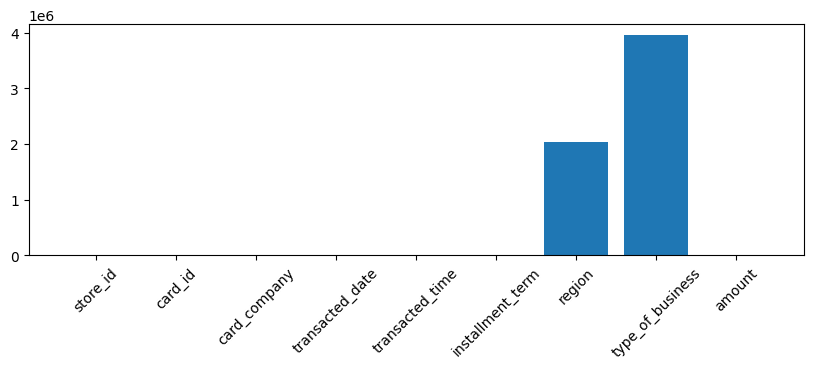

In [5]:
### 결측값이 있는 행 확인
plt.figure(figsize = (10, 3))
plt.bar(Train.columns, Train.isnull().sum())
plt.xticks(rotation = 45);

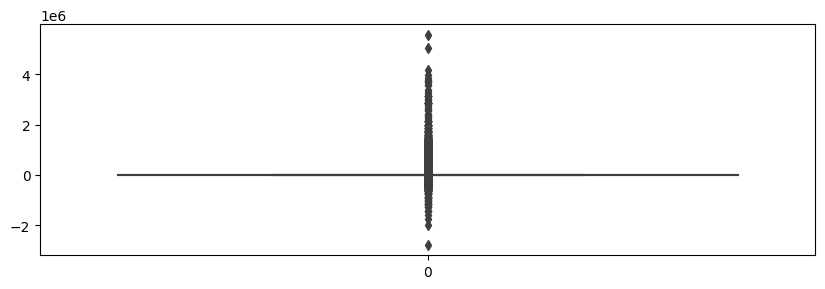

In [6]:
# 매출액(amount)에 대한 boxplot
plt.figure(figsize = (10, 3))
sns.boxplot(Train["amount"]);

In [7]:
### 거래일과 거래시간을 합친 변수 생성
Train["datetime"] = pd.to_datetime(Train.transacted_date + " " + Train.transacted_time,
                                   format = "%Y-%m-%d %H:%M:%S")

In [8]:
### 환불 거래 제거 함수
def remove_refund(data):
    refund = data[data["amount"] < 0]           # 매출액이 음수인 데이터 추출
    non_refund = data[data["amount"] > 0]       # 매출액이 양수인 데이터 추출

    removed_data = pd.DataFrame()

    for id in tqdm(data.store_id.unique()):
        divided_data = non_refund[non_refund["store_id"] == id]
        divided_data2 = refund[refund["store_id"] == id]

        for neg in divided_data2.to_records()[:]:   # 매출값이 음수인 데이터를 한 줄씩 불러옴

            # 환불 정보
            refund_store = neg["store_id"]          # 환불 매장
            refund_id = neg["card_id"]              # 환불 카드
            refund_datetime = neg["datetime"]       # 환불 시간
            refund_amount = abs(neg["amount"])      # 매출 음수값의 절대값(환불전 구매)

            # 환불 시기보다 빠르고, 같은 카드, 같은 금액 거래를 갖는 거래 후보 리스트 생성
            refund_pay_list = divided_data[divided_data["datetime"] <= refund_datetime]
            refund_pay_list = refund_pay_list[refund_pay_list["card_id"] == refund_id]
            refund_pay_list = refund_pay_list[refund_pay_list["amount"] == refund_amount]

            # 후보 리스트가 있으면서, 환불액이 같고 가장 최근 값을 제거
            if len(refund_pay_list) != 0 :
                # 가장 최근 시간
                refund_datetime = max(refund_pay_list["datetime"])
                noise_list = divided_data[divided_data["datetime"] == refund_datetime]

                # 환불 카드 ID
                noise_list = noise_list[noise_list["card_id"] == refund_id]

                # 환불액
                noise_list = noise_list[noise_list["amount"] == refund_amount]

                # 인덱스
                divided_data = divided_data.drop(index = noise_list.index)


        # 제거한 데이터를 데이터 프레임에 추가
        removed_data = pd.concat([removed_data, divided_data], axis = 0)


    return removed_data

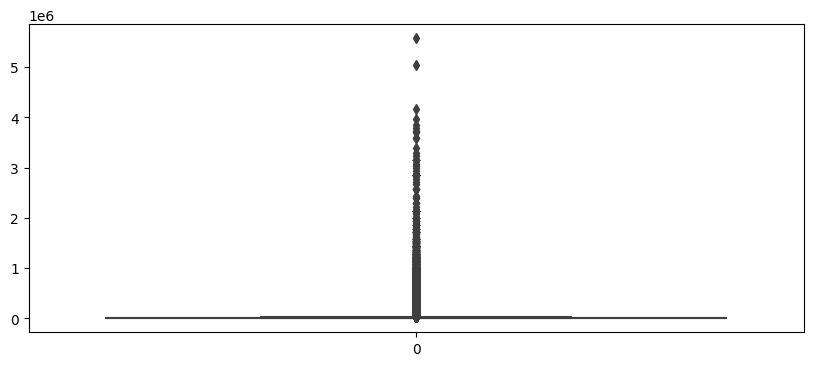

In [9]:
# # 환불을 고려한 데이터 제거 후 amount 확인
# positive_data = remove_refund(Train)
# positive_data.to_csv("./DAT/positive_data.csv", index = False)

positive_data = pd.read_csv("./DAT/positive_data.csv")
plt.figure(figsize = (10, 4))
sns.boxplot(positive_data["amount"]);

### **_다운 샘플링**

- 다운 샘플링을 통해 시간 간격을 넓게 조정해 데이터 샘플 수를 줄임

- 목표는 향후 3개월 동안 상점 매출의 총합을 구하는 것

- 시간 단위 amount  ->  월 단위 amount

- 이렇게 조정함으로써 예측해야하는 데이터 수 감소 = 불확실성 감소

In [11]:
display(positive_data.head())

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,datetime
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016-06-02 11:06:00


In [16]:
### 월 단위 다운 샘플링 함수
def month_resampling(data):

    new_data = pd.DataFrame()

    # 년도와 월을 합친 변수 생성
    data["year_month"] = data["transacted_date"].str.slice(stop = 7)

    # 데이터의 전체 기간을 추출
    year_month = data["year_month"].drop_duplicates()

    # 상점 ID별로 월 단위 매출액 총합 계산
    downsampling_data = data.groupby(["store_id", "year_month"]).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop = False, inplace = False)

    for id in tqdm(data.store_id.unique()):

        # 상점별로 데이터 처리
        store = downsampling_data[downsampling_data["store_id"] == id]

        # 각 상점의 처음 매출이 발생한 월을 계산
        start_time = min(store["year_month"])

        # 모든 상점을 전체 기간 데이터로 생성
        store = store.merge(year_month, how = "outer")

        # 데이터를 시간순으로 정렬
        store = store.sort_values(by = ["year_month"], axis = 0, ascending = True)

        # 매출이 발생하지 않은 월은 2로 채움(추후 진동폭 안정화를 위한 로그 정규화를 위해 2로 채움)
        store["amount"] = store["amount"].fillna(2)

        # 상점 ID 결측치를 채움
        store["store_id"] = store["store_id"].fillna(id)

        # 처음 매출이 발생한 월 이후만 추출
        store = store[store["year_month"] >= start_time]

        new_data = pd.concat([new_data, store], axis = 0)

    return new_data

In [17]:
resampling_data = month_resampling(positive_data)
resampling_data["store_id"] = resampling_data["store_id"].astype(int)
print(resampling_data.shape)
resampling_data

  0%|          | 0/1967 [00:00<?, ?it/s]

(60982, 3)


,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.127643e+06
19,2136,2018-12,2.427429e+06
20,2136,2019-01,1.867786e+06


### **_날짜 지정 범위 생성과 시리즈 객체 변환**

- 시계열 데이터 분석을 위해 DF -> Series 객체로 변환

- 시계열 데이터의 '정상성'을 확인하기 위해 단위근 검정 수행

In [22]:
print(type(resampling_data))

# DF를 Series로 변환 함수
def time_series(data, id):

    # 상점별로 데이터 추출
    store = data[data["store_id"] == id]

    # 날짜 지정 범위는 영업 시작 월 ~ 2019년 3월 전까지 영업 마감일 기준
    index = pd.date_range(min(store["year_month"]), "2019-03", freq = "BM")

    # 시리즈 객체로 변환
    ts = pd.Series(store["amount"].values, index = index)

    return ts

<class 'pandas.core.frame.DataFrame'>


2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
Freq: BM, dtype: float64
<class 'pandas.core.series.Series'>


<Axes: >

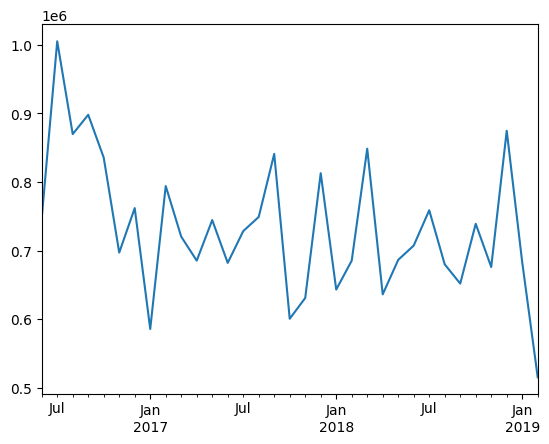

In [25]:
# 상점ID가 0인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)
print(store_0.head())
print(type(store_0))
store_0.plot()

## **탐색적 데이터 분석(EDA)**

- 상점별 매출액 시계열 그래프를 통해 매출 특성 파악

- 시계열 데이터의 평균과 분산이 안정적인지 확인하기 위해 ADF-TEST 진행

### **_상점별 매출 특성**

- 상점의 특징을 구분
    1. 계절성이 있는 상점
    2. 추세가 있는 상점
    3. 휴업 중인 상점

#### **계절성이 있는 상점**

- 우리의 목표 예측 시기 특징 = 봄, 1학기, 상반기, 꽃 축제, 가정의 달, 황금연휴


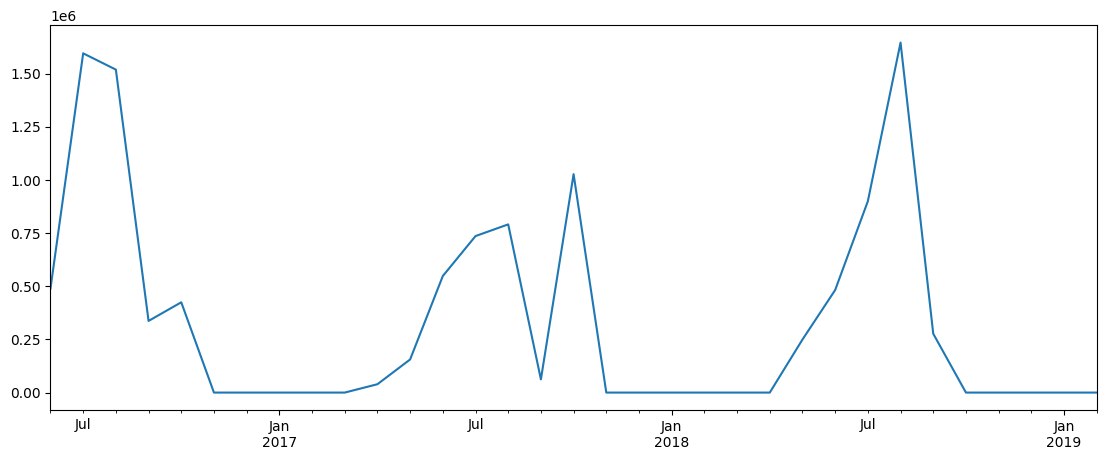

In [27]:
### 예시 Store ID = 257
# 11월 ~ 3월에는 매출이 없음
# 여름(7~8월)에 많은 매출 발생
# 예측할 3~5월에는 많은 매출이 발생하지 않음

store_257 = time_series(resampling_data, 257)

store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5, 5)

#### **추세가 있는 상점**

- 매출이 꾸준히 증가 또는 감소하는 상점

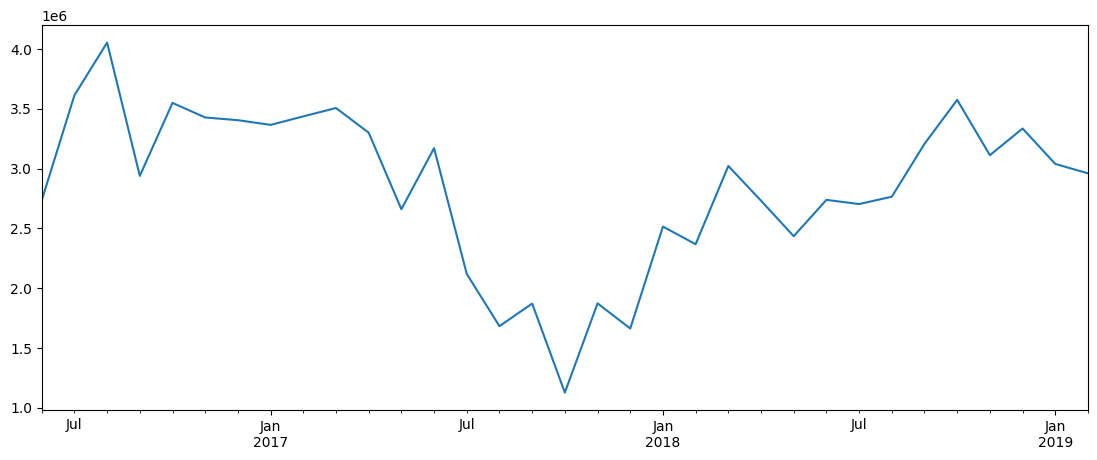

In [28]:
### 예시 Store ID = 335
# 2016-06 ~ 2017-10: 매출액 감소
# 2017-11 ~ 2019-02: 매출액 증가
store_335 = time_series(resampling_data, 335)

store_plot_335 = store_335.plot()
fig = store_plot_335.get_figure()
fig.set_size_inches(13.5, 5)

#### **휴업 중인 상점**

- 몇 개월 동안 매출이 발생하지 않은 상점

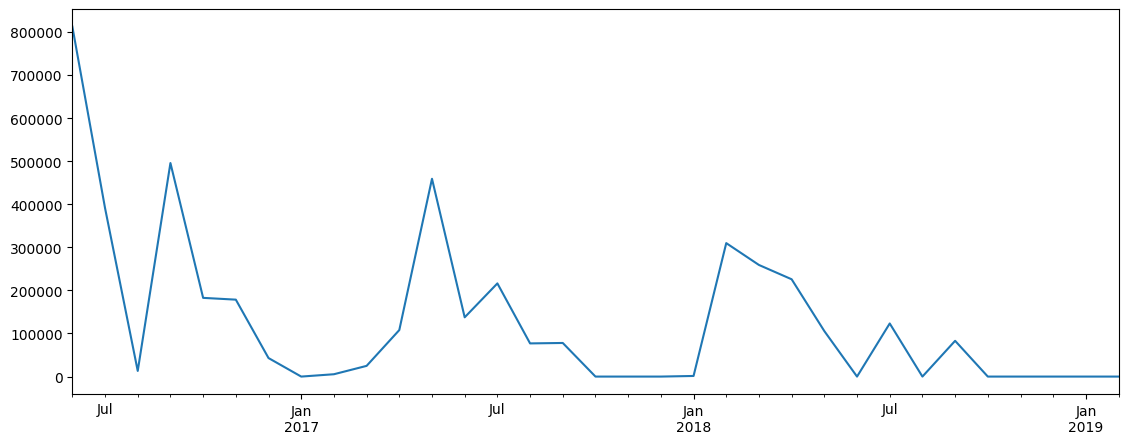

In [29]:
### 예시 Store ID = 111
store_111 = time_series(resampling_data, 111)

store_plot_111 = store_111.plot()
fig = store_plot_111.get_figure()
fig.set_size_inches(13.5, 5)

### **_시계열 데이터의 정상성**

- 정상성을 갖는 데이터 = 추세나 계절성이 없는 시계열 데이터

In [32]:
# 정상 시계열 데이터 store_0
p_val, should_diff = ADFTest().should_diff(store_0)
print("p_val : %.5f, should_diff: %s" % (p_val, should_diff))

p_val : 0.02249, should_diff: False


In [33]:
# 비정상 시계열 데이터 store_257
p_val, should_diff = ADFTest().should_diff(store_257)
print("p_val : %.5f, should_diff: %s" % (p_val, should_diff))

p_val : 0.09361, should_diff: True


  0%|          | 0/1967 [00:00<?, ?it/s]

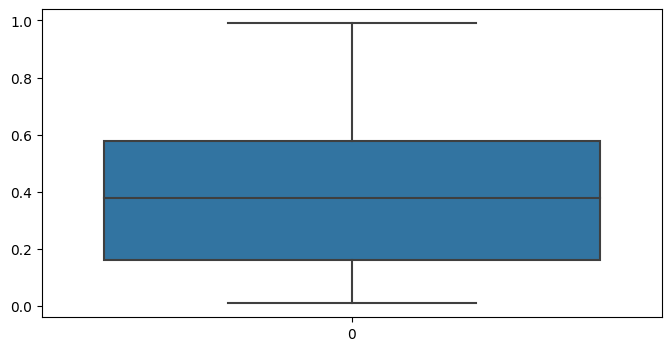

In [38]:
### ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]


### 전체 상점 adf_test p-value 값을 리스트에 저장 후 boxplot
adf_p = []
count = 0
skipped = []

for id in tqdm(resampling_data["store_id"].unique()):
    ts = time_series(resampling_data, id)

    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)

    except:
        skipped.append(id)

plt.figure(figsize = (8, 4))
sns.boxplot(adf_p);

In [39]:
print("p-value < 0.05인 상점 수: ", count)

# ADF-TEst 오류 상점
if skipped:
    print(f"WarningCount: {len(skipped)} |  store_id_list:{skipped}")

p-value < 0.05인 상점 수:  259


## **모델 구축(선택)과 검증**

- 시계열 모델을 구축하고 검증하는 과정을 수행

- R forecast 패키지를 파이썬과 연동

- ARIMA 모델, 지수평활법, STL 분해를 적용한 지수평활법 등의 시계열 모델을 활용해 예측

### **_모델 구축 예시**

In [44]:
### pandas2ri를 활성화
pandas2ri.activate()

auto_arima = """
                function(ts){   library(forecast)                               # forecast 패키지 로드
                                d_params = ndiffs(ts)                           # 시계열 자료의 차분 횟수 계산
                                model = auto.arima(ts, max.p = 2, d = d_params) # auto.arima 모델 생성
                                forecasted_data = forecast(model, h = 3)        # 이후 3개월을 예측
                                out_df = data.frame(forecasted_data$mean)       # 예측값을 R의 데이터 프레임으로 변환
                                colnames(out_df) = c("amount")                  # amount라는 열로 이름을 지정
                                out_df  }
             """

### r()함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수

In [51]:
### Store ID = 0
store_0 = resampling_data[resampling_data["store_id"] == 0]
start_year = int(min(store_0["year_month"])[:4])        # 영업 시작 년도
start_month = int(min(store_0["year_month"])[5:])       # 영업 시작 월


### R의 ts함수로 r의 time series 자료형으로 변환
train = ts(store_0["amount"], start = c(start_year, start_month), frequency = 12)


### ensemble model
forecast = auto_arima(train)

# 3개월 매출을 합산
# np.sum(pandas2ri.ri2py(forecast).values)

# 3개월 매출을 합산 - 위의 코드가 안되는 경우
np.sum(robjects.conversion.py2rpy(forecast))

2007226.9729129502

### **_ARIMA 모델**

In [52]:
### pandas2ri를 활성화
pandas2ri.activate()

auto_arima = """
                function(ts){   library(forecast)                               # forecast 패키지 로드
                                d_params = ndiffs(ts)                           # 시계열 자료의 차분 횟수 계산
                                model = auto.arima(ts, max.p = 2, d = d_params) # auto.arima 모델 생성
                                forecasted_data = forecast(model, h = 3)        # 이후 3개월을 예측
                                out_df = data.frame(forecasted_data$mean)       # 예측값을 R의 데이터 프레임으로 변환
                                colnames(out_df) = c("amount")                  # amount라는 열로 이름을 지정
                                out_df  }
             """

### r()함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수

In [55]:
final_pred = []

for id in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data["store_id"] == id]
    start_year = int(min(store["year_month"])[:4])        # 영업 시작 년도
    start_month = int(min(store["year_month"])[5:])       # 영업 시작 월

    # R의 ts함수로 r의 time series 자료형으로 변환
    train = ts(store["amount"], start = c(start_year, start_month), frequency = 12)

    # ARIMA model
    forecast = auto_arima(train)

    # 3개월 매출을 합산 및 final_pred에 추가
    # final_pred.append(np.sum(pandas2ri.ri2py(forecast).values)    )
    final_pred.append(np.sum(robjects.conversion.py2rpy(forecast)))   # 위의 코드가 안되는 경우



# 결과 저장
submission = pd.read_csv("./DAT/submission.csv")
submission["amount"] = final_pred
submission.to_csv("./OUT/ARIMA model.csv", index = False)
submission.head()

  0%|          | 0/1967 [00:00<?, ?it/s]

,store_id,amount
0,0,2.007227e+06
1,1,2.886210e+05
2,2,1.276695e+06
3,4,2.697649e+06
4,5,6.465429e+05


### **_지수 평활법**

In [57]:
### pandas2ri를 활성화
pandas2ri.activate()

ets = """
        function(ts){   library(forecast)                               # forecast 패키지 로드
                        model = ets(ts)                                 # AIC가 낮은 지수평활 모델 찾음
                        forecasted_data = forecast(model, h = 3)        # 이후 3개월을 예측
                        out_df = data.frame(forecasted_data$mean)       # 예측값을 R의 데이터 프레임으로 변환
                        colnames(out_df) = c("amount")                  # amount라는 열로 이름을 지정
                        out_df  }
      """

### r()함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수

In [58]:
final_pred = []

for id in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data["store_id"] == id]
    start_year = int(min(store["year_month"])[:4])        # 영업 시작 년도
    start_month = int(min(store["year_month"])[5:])       # 영업 시작 월

    # R의 ts함수로 r의 time series 자료형으로 변환
    train = ts(store["amount"], start = c(start_year, start_month), frequency = 12)

    # ETS model
    forecast = ets(train)

    # 3개월 매출을 합산 및 final_pred에 추가
    # final_pred.append(np.sum(pandas2ri.ri2py(forecast).values)    )
    final_pred.append(np.sum(robjects.conversion.py2rpy(forecast)))   # 위의 코드가 안되는 경우


# 결과 저장
submission = pd.read_csv("./DAT/submission.csv")
submission["amount"] = final_pred
submission.to_csv("./OUT/ETS model.csv", index = False)
submission.head()

  0%|          | 0/1967 [00:00<?, ?it/s]

,store_id,amount
0,0,2.060501e+06
1,1,2.878790e+05
2,2,1.260318e+06
3,4,2.668637e+06
4,5,7.091162e+05


### **_STL분해를 적용한 지수평활법**

- STL : Season and Trend decomposition using Loss

In [68]:
# ### Store ID = 0에 대해 STL 분해 적용 예시
# stl = seasonal_decompose(store_0.values, period = 12)
# stl.plot();

In [75]:
### pandas2ri를 활성화
pandas2ri.activate()

stlm = """
        function(ts){   library(forecast)                                       # forecast 패키지 로드
                        model = stlm(ts, s.window = "periodic", method = "ets")  # STL분해 후 지수평활법을 통한 예측
                        forecasted_data = forecast(model, h = 3)                # 이후 3개월을 예측
                        out_df = data.frame(forecasted_data$mean)               # 예측값을 R의 데이터 프레임으로 변환
                        colnames(out_df) = c("amount")                          # amount라는 열로 이름을 지정
                        out_df  }
        """

ets = """
        function(ts){   library(forecast)                               # forecast 패키지 로드
                        model = ets(ts)                                 # AIC가 낮은 지수평활 모델 찾음
                        forecasted_data = forecast(model, h = 3)        # 이후 3개월을 예측
                        out_df = data.frame(forecasted_data$mean)       # 예측값을 R의 데이터 프레임으로 변환
                        colnames(out_df) = c("amount")                  # amount라는 열로 이름을 지정
                        out_df  }
      """

### r()함수로 r 자료형을 파이썬에서 사용 가능
stlm = robjects.r(stlm)     # str 형식으로 정의된 stlm
ets = robjects.r(ets)       # str 형식으로 정의된 ets
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수

In [84]:
final_pred = []

for id in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data["store_id"] == id]
    data_len = len(store)
    start_year = int(min(store["year_month"])[:4])        # 영업 시작 년도
    start_month = int(min(store["year_month"])[5:])       # 영업 시작 월

    # R의 ts함수로 r의 time series 자료형으로 변환
    train = ts(store["amount"], start = c(start_year, start_month), frequency = 12)


    # STL 분해를 적용한 ETS model
    if data_len > 36:           # 책에서는 24가 기준이지만 36으로 해야 돌아감
        forecast = stlm(train)
    else:
        forecast = ets(train)

    # 3개월 매출을 합산 및 final_pred에 추가
    # final_pred.append(np.sum(pandas2ri.ri2py(forecast).values)    )
    final_pred.append(np.sum(robjects.conversion.py2rpy(forecast)))   # 위의 코드가 안되는 경우


# 결과 저장
submission = pd.read_csv("./DAT/submission.csv")
submission["amount"] = final_pred
submission.to_csv("./OUT/STL model.csv", index = False)
submission.head()

  0%|          | 0/1967 [00:00<?, ?it/s]

,store_id,amount
0,0,2.060501e+06
1,1,2.878790e+05
2,2,1.260318e+06
3,4,2.668637e+06
4,5,7.091162e+05


## **성능 향상을 위한 방법**

- 향상 방법
    1. 데이터 전처리: 상점 매출애긔 로그 정규화
    2. 모델 앙상블: R의 forecastHybrid 패키지를 이용한 앙상블



### **_상점 매출액의 로그 정규화**

- 로그 정규화를 한다고 반드시 좋아지는 것이 아님
- 변동계수를 고려해 로그 정규화 수행 (변동계수 < 0.3인 상점만 로그 정규화)
- 변동계수: 표준편차를 평균으로 나눈 지표

#### **Store ID = 0을 활용한 예시**

In [86]:
### pandas2ri를 활성화
pandas2ri.activate()

auto_arima = """
                function(ts){   library(forecast)                               # forecast 패키지 로드
                                d_params = ndiffs(ts)                           # 시계열 자료의 차분 횟수 계산
                                model = auto.arima(ts, max.p = 2, d = d_params) # auto.arima 모델 생성
                                forecasted_data = forecast(model, h = 3)        # 이후 3개월을 예측
                                out_df = data.frame(forecasted_data$mean)       # 예측값을 R의 데이터 프레임으로 변환
                                colnames(out_df) = c("amount")                  # amount라는 열로 이름을 지정
                                out_df  }
             """

### r()함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수
log = robjects.r("log")     # 로그 변환 함수
exp = robjects.r("exp")     # 로그 역변환 함수

### Store ID = 0
store_0 = resampling_data[resampling_data["store_id"] == 0]
start_year = int(min(store_0["year_month"])[:4])        # 영업 시작 년도
start_month = int(min(store_0["year_month"])[5:])       # 영업 시작 월


### train, test 분리
train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]


### R의 ts함수로 r의 time series 자료형으로 변환
# log 정규화
train_log = ts(log(train["amount"]), start = c(start_year, start_month), frequency = 12)
train = ts(store_0["amount"], start = c(start_year, start_month), frequency = 12)


### model arima
forecast_log = auto_arima(train_log)
forecast = auto_arima(train)


### pred
pred_log = np.sum(robjects.conversion.py2rpy(exp(forecast_log)))
pred = np.sum(robjects.conversion.py2rpy(forecast))

### test(2018-12 ~ 2019-02)
test = np.sum(test["amount"])

### MAE
print("Log-regularization MAE: ", abs(test - pred_log))
print("MAE: ", abs(test - pred))

Log-regularization MAE:  2401.9663503926713
MAE:  65487.31280133547


#### **변동계수 기반 로그 정규화**

In [87]:
### 매출 변동계수를 구하는 함수
def coefficient_variation(data, id):
    cv_data = data.groupby(["store_id"]).amount.std()/data.groupby(["store_id"]).amount.mean()
    cv = cv_data[id]
    return cv

In [88]:
### pandas2ri를 활성화
pandas2ri.activate()

# 가장 성능이 좋았던 ETS 기반 모델
ets = """
        function(ts){   library(forecast)                               # forecast 패키지 로드
                        model = ets(ts)                                 # AIC가 낮은 지수평활 모델 찾음
                        forecasted_data = forecast(model, h = 3)        # 이후 3개월을 예측
                        out_df = data.frame(forecasted_data$mean)       # 예측값을 R의 데이터 프레임으로 변환
                        colnames(out_df) = c("amount")                  # amount라는 열로 이름을 지정
                        out_df  }
      """


### r()함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수
log = robjects.r("log")     # 로그 변환 함수
exp = robjects.r("exp")     # 로그 역변환 함수

In [91]:
final_pred = []

for id in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data["store_id"] == id]
    start_year = int(min(store["year_month"])[:4])        # 영업 시작 년도
    start_month = int(min(store["year_month"])[5:])       # 영업 시작 월

    cv = coefficient_variation(resampling_data, id)
    # 매출액의 변동계수가 0.3미만인 경우만 log
    if cv < 0.3:
        train_log = ts(log(store["amount"]), start = c(start_year, start_month), frequency = 12)
        forecast_log = ets(train_log)
        final_pred.append(np.sum(robjects.conversion.py2rpy(forecast_log)))

    else:
        train = ts(store["amount"], start = c(start_year, start_month), frequency = 12)
        forecast_log = ets(train)
        final_pred.append(np.sum(robjects.conversion.py2rpy(forecast)))


# 결과 저장
submission = pd.read_csv("./DAT/submission.csv")
submission["amount"] = final_pred
submission.to_csv("./OUT/CV + ETS model.csv", index = False)
submission.head()

  0%|          | 0/1967 [00:00<?, ?it/s]

,store_id,amount
0,0,4.017470e+01
1,1,3.397153e+01
2,2,2.007227e+06
3,4,4.108609e+01
4,5,2.007227e+06


### **_R 패키지 forecastHybrid를 통한 앙상블**

In [92]:
### pandas2ri를 활성화
pandas2ri.activate()

# 가장 성능이 좋았던 ETS 기반 모델
hybridModel = """
                function(ts){   library(forecast)
                                library(forecastHybrid)
                                d_params = ndiffs(ts)
                                hb_model <- hybridModel(ts, models = "aes",                     # auto_arima, ets, stlm
                                                        a.arg = list(max.p = 2, d = d_params),  # auto_arima's parameters
                                                        weight = "equal")                       # 앙상블 시 가중치 동일하게 줌(= 평균)
                                forecasted_data = forecast(hb_model, h = 3)
                                out_df = data.frame(forecasted_data$mean)
                                colnames(out_df) = c("amount")
                                out_df  }
              """


### r()함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r("ts")       # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r("c")         # r 자료형 벡터를 만들어주는 함수
log = robjects.r("log")     # 로그 변환 함수
exp = robjects.r("exp")     # 로그 역변환 함수

In [93]:
final_pred = []

for id in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data["store_id"] == id]
    start_year = int(min(store["year_month"])[:4])        # 영업 시작 년도
    start_month = int(min(store["year_month"])[5:])       # 영업 시작 월

    cv = coefficient_variation(resampling_data, id)
    # 매출액의 변동계수가 0.3미만인 경우만 log
    if cv < 0.3:
        train_log = ts(log(store["amount"]), start = c(start_year, start_month), frequency = 12)
        forecast_log = hybridModel(train_log)
        final_pred.append(np.sum(robjects.conversion.py2rpy(forecast_log)))

    else:
        train = ts(store["amount"], start = c(start_year, start_month), frequency = 12)
        forecast_log = hybridModel(train)
        final_pred.append(np.sum(robjects.conversion.py2rpy(forecast)))


# 결과 저장
submission = pd.read_csv("./DAT/submission.csv")
submission["amount"] = final_pred
submission.to_csv("./OUT/CV + Ensemble(AES).csv", index = False)
submission.head()

  0%|          | 0/1967 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.






































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































,store_id,amount
0,0,4.022933e+01
1,1,3.414196e+01
2,2,2.007227e+06
3,4,4.109195e+01
4,5,2.007227e+06
